In [1]:
from src.data_utils.base_datamodule import DataModule

from sklearn.datasets import fetch_openml
import os
import pickle
from types import SimpleNamespace
from typing import Tuple, List
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

class DiabetesDataModule(DataModule):
    def __init__(self
        ) -> None:
        super().__init__('diabetes')
    
    def load_data(self) -> Tuple[pd.DataFrame, pd.Series]:
        diabetes = fetch_openml(data_id = 37, data_home='./data_cache')

        data = diabetes.data
        
        le = LabelEncoder()
        label = pd.Series(le.fit_transform(diabetes.target))

        return data, label
    
    def prepare_data(self) -> Tuple[pd.DataFrame, pd.Series, List[str], List[str]]:

        data, label = self.load_data()

        categorical_cols = []
        
        numeric_cols = list(map(str, data.columns))
            
        return data, label.values, numeric_cols, categorical_cols

In [2]:
test_size = 0.2
random_seed = 42

In [3]:
from sklearn.model_selection import train_test_split
from kamir  import KamirDataModule
def prepare_data() -> Tuple[pd.DataFrame, np.array, pd.DataFrame, np.array]:
    datamodule = DiabetesDataModule()
    # import yaml
    # with open('data_config/6M_mortality.yaml', 'rb') as f:
    #     config = yaml.load(f, Loader=yaml.FullLoader)
    # datamodule = KamirDataModule("binary", SimpleNamespace(**config))
    data, label, continuous_cols, categorical_cols = datamodule.prepare_data()

    train_idx, test_idx, _, _ = train_test_split(np.arange(len(label)).reshape((-1, 1)), label, test_size=test_size, random_state=random_seed, stratify=label)
    train_idx, test_idx = train_idx.ravel(), test_idx.ravel()

    X_test, y_test = data.iloc[test_idx], label[test_idx]
    data, label = data.iloc[train_idx], label[train_idx]
    
    return data, label, X_test, y_test, continuous_cols, categorical_cols

In [4]:
import importlib

def prepare_config(target_config: str) -> SimpleNamespace:
    configlib = importlib.import_module('src.config')
    config = getattr(configlib, target_config)
    
    config.model.out_dim = 2
    
    config.experiment.metric = "accuracy_score"
    config.experiment.metric_params = []
    config.experiment.data_config = "diabetes"
    config.experiment.optuna.direction = 'maximize'
    config.experiment.random_seed = random_seed
    config.experiment.task = "binary"
    
    config.experiment.optuna.n_trials = 1
    
    config.experiment.calibrator = "HistogramBinning"
    
    config.experiment.KFold = 1
    config.experiment.early_stopping_patience = 1
    config.dice.backend = "sklearn"
    config.dice.desired_class = 0
    
    config.experiment.fast_dev_run = True
    return config

In [5]:
data, label, X_test, y_test, continuous_cols, categorical_cols = prepare_data()
# continuous_cols = list(map(str, data.columns))
# data.columns = continuous_cols
config = prepare_config('xgb_config')

/opt/conda/envs/jamia/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [6]:
from src.rias import RIAS
def prepare_rias(config: SimpleNamespace, X: pd.DataFrame, y: np.array, continuous_cols: List[str], categorical_cols: List[str]) -> RIAS:
    modellib = importlib.import_module('src.models')
    model_class = getattr(modellib, config.model.model_class)

    rias = RIAS(config = config, model_class=model_class, X=X, y = y, continuous_cols=continuous_cols, categorical_cols=categorical_cols)
    
    return rias

/opt/conda/envs/jamia/lib/python3.8/site-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "


In [7]:
from src.models import BaseModel
from src.misc.eval_metric import EvalMetric
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, recall_score, average_precision_score
from typing import Type

class DiabetesEvalMetric(EvalMetric):
    def eval(self, model: Type[BaseModel], X_test: pd.DataFrame, y_test: np.array):
        preds_proba = model.predict_proba(X_test)
        preds = preds_proba.argmax(1)
        
        f1 = f1_score(y_test, preds)
        roc = roc_auc_score(y_test, preds_proba[:, 1])
        specificity = recall_score(np.logical_not(y_test) , np.logical_not(preds))
        sensitivity = recall_score(y_test, preds)
        accuracy = accuracy_score(y_test, preds)
        pr_auc = average_precision_score(y_test, preds_proba[:, 1])
        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
        ppv = tp / (tp + fp)
        npv = tn / (tn + fn)
        
        print("F1 Score: %.4f" % f1)
        print("ROC AUC Score: %.4f" % roc)
        print("Specificity Score: %.4f" % specificity)
        print("Sensitivity Score: %.4f" % sensitivity)
        print("Accuracy Score: %.4f" % accuracy)
        print("Precision Recall AUC Score: %.4f" % pr_auc)
        print("PPV Score: %.4f" % ppv)
        print("NPV Score: %.4f" % npv)

        return {
            "F1 Score" : f1,
            "ROC AUC Score" : roc,
            "Specificity Score" : specificity,
            "Sensitivity Score" : sensitivity,
            "Accuracy Score" : accuracy,
            "Precision Recall AUC Score" : pr_auc,
            "PPV Score" : ppv,
            "NPV Score" : npv
        }

In [8]:
rias = prepare_rias(config, data, label, continuous_cols, categorical_cols)

rias.train()

rias.init_calibrator()
rias.test(X_test, y_test, DiabetesEvalMetric())

2023-10-17 16:18:10.940454: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 16:18:11.422628: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[I 2023-10-17 16:18:11,877] A new study created in memory with name: no-name-5e88a496-3ee4-47e4-91e5-90a0954faa04
[I 2023-10-17 16:18:11,938] Trial 0 finished with value: 0.6747967479674797 and parameters: {'max_leaves': 1686, 'n_estimators': 2853, 'learning_rate': 0.7319939418114051, 'max_depth': 13, 'scale_pos_weight': 16}. Best is trial 0 with value: 0.6747967479674797.


Best Parameters
{'max_leaves': 1686, 'n_estimators': 2853, 'learning_rate': 0.7319939418114051, 'max_depth': 13, 'scale_pos_weight': 16}
Validation Score: 0.6748
Uncalibrated ECE : 0.23488494976446397
Calibrated ECE : 7.3337903049426e-17
F1 Score: 0.6466
ROC AUC Score: 0.7936
Specificity Score: 0.6400
Sensitivity Score: 0.7963
Accuracy Score: 0.6948
Precision Recall AUC Score: 0.6888
PPV Score: 0.5443
NPV Score: 0.8533


{'F1 Score': 0.6466165413533835,
 'ROC AUC Score': 0.7936111111111112,
 'Specificity Score': 0.64,
 'Sensitivity Score': 0.7962962962962963,
 'Accuracy Score': 0.6948051948051948,
 'Precision Recall AUC Score': 0.6887746728351708,
 'PPV Score': 0.5443037974683544,
 'NPV Score': 0.8533333333333334}

In [9]:
dice_d = X_test.iloc[:10].copy()

In [10]:
dice = rias.dice(dice_d)

100%|██████████| 10/10 [00:00<00:00, 12.71it/s]

Query instance (original outcome : 1)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,7.0,159.0,64.0,0.0,0.0,27.4,0.294,40.0,1



Diverse Counterfactual set (new outcome: 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,7.0,19.5,64.0,0.0,561.5,27.4,0.294,40.0,0
1,7.0,146.8,64.0,0.0,0.0,6.7,0.294,40.0,0
2,7.0,8.4,64.0,0.0,0.0,27.4,0.527,40.0,0
3,7.0,8.4,64.0,0.0,442.2,27.4,0.294,40.0,0


Query instance (original outcome : 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,10.0,68.0,106.0,23.0,49.0,35.5,0.285,47.0,0



Diverse Counterfactual set (new outcome: 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,10.0,68.0,106.0,23.0,49.0,35.5,0.285,29.6,0
1,10.0,68.0,106.0,23.0,49.0,40.3,0.285,47.0,0
2,10.0,68.0,106.0,23.0,49.0,7.1,0.285,47.0,0
3,10.0,68.0,106.0,23.0,49.0,35.5,0.284,47.0,0


Query instance (original outcome : 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,2.0,122.0,76.0,27.0,200.0,35.900002,0.483,26.0,0



Diverse Counterfactual set (new outcome: 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,14.9,49.5,76.0,27.0,200.0,35.9,0.483,26.0,0
1,2.0,122.0,76.0,27.0,429.4,35.9,0.483,26.0,0
2,2.0,122.0,76.0,27.0,200.0,35.9,0.483,26.0,0
3,10.6,122.0,76.0,27.0,200.0,35.9,0.406,26.0,0


Query instance (original outcome : 1)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,7.0,114.0,64.0,0.0,0.0,27.4,0.732,34.0,1



Diverse Counterfactual set (new outcome: 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,7.0,114.0,64.0,0.0,0.0,1.4,0.732,56.1,0
1,7.0,114.0,23.7,0.0,0.0,14.5,0.732,34.0,0
2,7.0,114.0,64.0,0.0,0.0,19.0,0.732,34.0,0
3,7.0,114.0,64.0,0.0,0.0,25.7,0.732,34.0,0


Query instance (original outcome : 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,2.0,74.0,0.0,0.0,0.0,0.0,0.102,22.0,0



Diverse Counterfactual set (new outcome: 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,2.0,74.0,0.0,0.0,0.0,0.000000e+00,0.102,22.0,0
1,16.7,74.0,0.0,0.0,0.0,0.000000e+00,0.102,59.6,0
2,14.9,74.0,0.0,0.0,0.0,1.387779e-16,0.102,22.0,0
3,2.0,74.0,0.0,0.0,0.0,0.000000e+00,0.102,41.6,0


Query instance (original outcome : 1)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,3.0,100.0,68.0,23.0,81.0,31.6,0.949,28.0,1



Diverse Counterfactual set (new outcome: 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,3.0,100.0,68.0,23.0,81.0,3.8,0.949,80.2,0
1,3.0,100.0,68.0,23.0,81.0,31.6,0.087,28.0,0
2,3.0,120.4,68.0,23.0,16.8,31.6,0.949,28.0,0
3,3.0,100.0,68.0,23.0,81.0,15.0,0.225,28.0,0


Query instance (original outcome : 1)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,8.0,105.0,100.0,36.0,0.0,43.299999,0.239,45.0,1



Diverse Counterfactual set (new outcome: 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,8.0,51.2,100.0,36.0,0.0,43.3,0.239,45.0,0
1,8.0,105.0,100.0,36.0,0.0,10.1,0.239,45.0,0
2,8.0,40.6,100.0,36.0,0.0,43.3,0.239,45.0,0
3,1.0,105.0,100.0,36.0,0.0,43.3,0.239,60.0,0


Query instance (original outcome : 1)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,8.0,197.0,74.0,0.0,0.0,25.9,1.191,39.0,1



Diverse Counterfactual set (new outcome: 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,8.0,132.1,74.0,0.0,285.7,25.9,1.191,39.0,0
1,13.3,77.3,74.0,0.0,0.0,25.9,1.191,39.0,0
2,8.0,91.7,74.0,0.0,0.0,25.9,1.191,39.0,0
3,8.0,10.6,74.0,0.0,0.0,25.9,1.191,39.0,0


Query instance (original outcome : 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,2.0,100.0,64.0,23.0,0.0,29.700001,0.368,21.0,0



Diverse Counterfactual set (new outcome: 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,2.0,100.0,95.2,23.0,0.0,29.7,0.368,21.0,0
1,2.0,100.0,7.2,23.0,0.0,29.7,0.368,21.0,0
2,2.0,100.0,64.0,23.0,0.0,29.7,0.368,21.0,0
3,2.0,15.0,64.0,23.0,291.0,29.7,0.368,21.0,0


Query instance (original outcome : 1)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,0.0,165.0,76.0,43.0,255.0,47.900002,0.259,26.0,1



Diverse Counterfactual set (new outcome: 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,0.0,104.8,76.0,43.0,624.0,47.9,0.259,26.0,0
1,0.0,99.4,76.0,43.0,255.0,47.9,0.259,26.0,0
2,0.0,81.7,76.0,43.0,255.0,47.9,0.259,26.0,0
3,0.0,23.7,76.0,43.0,255.0,47.9,0.259,26.0,0


In [11]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(data.values, feature_names=data.columns, class_names=["0", "1"], verbose=True, mode='classification', discretize_continuous=True)

In [12]:
exp = explainer.explain_instance(X_test.iloc[0], rias.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)

Intercept 0.43764045177922417
Prediction_local [0.76735139]
Right: 0.9294288


In [13]:
rias.init_shap_explainer()
rias.init_shap_base_values()

Permutation explainer: 615it [00:33, 13.66it/s]                         


In [14]:
fig = rias.report_pred(X_test.iloc[15], 1)

[[0.27547204 0.72452796]]


In [15]:
rias.calculate_feature_importance()

  0%|          | 0/100 [00:00<?, ?it/s]

7 attributes confirmed important: ['pedi', 'plas', 'mass', 'insu', 'skin', 'age', 'preg']
0 attributes confirmed unimportant: []
1 tentative attributes remains: ['pres']


In [16]:
import random
B = rias.feature_importances.copy()
random.shuffle(B.Features)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


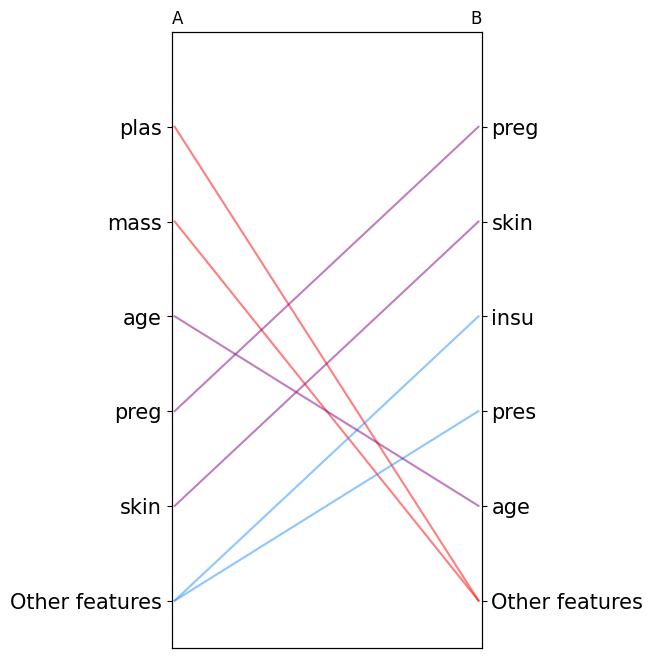

In [36]:
%load_ext autoreload
%autoreload 2
from src.visualization import difference_between_important_features

difference_between_important_features(rias.feature_importances, B, 'A', 'B', top_k=5)

In [34]:
rias.report_recursive_feature_elimination(X_test, y_test, DiabetesEvalMetric())

  0%|          | 0/2 [00:00<?, ?it/s][I 2023-10-17 00:01:02,935] A new study created in memory with name: no-name-a9f6be44-67fc-4542-a854-9faffcca2c0e
[I 2023-10-17 00:01:02,973] Trial 0 finished with value: 0.6747967479674797 and parameters: {'max_leaves': 1686, 'n_estimators': 2853, 'learning_rate': 0.7319939418114051, 'max_depth': 13, 'scale_pos_weight': 16}. Best is trial 0 with value: 0.6747967479674797.
[I 2023-10-17 00:01:03,010] A new study created in memory with name: no-name-15c0b720-b790-4de5-ac21-f7ff3cf6d74f
[I 2023-10-17 00:01:03,039] Trial 0 finished with value: 0.7073170731707317 and parameters: {'max_leaves': 1686, 'n_estimators': 2853, 'learning_rate': 0.7319939418114051, 'max_depth': 13, 'scale_pos_weight': 16}. Best is trial 0 with value: 0.7073170731707317.
100%|██████████| 2/2 [00:00<00:00, 14.71it/s]

Best Parameters
{'max_leaves': 1686, 'n_estimators': 2853, 'learning_rate': 0.7319939418114051, 'max_depth': 13, 'scale_pos_weight': 16}
F1 Score: 0.6466
ROC AUC Score: 0.7936
Specificity Score: 0.6400
Sensitivity Score: 0.7963
Accuracy Score: 0.6948
Precision Recall AUC Score: 0.6888
PPV Score: 0.5443
NPV Score: 0.8533
Best Parameters
{'max_leaves': 1686, 'n_estimators': 2853, 'learning_rate': 0.7319939418114051, 'max_depth': 13, 'scale_pos_weight': 16}
F1 Score: 0.6290
ROC AUC Score: 0.7872
Specificity Score: 0.6900
Sensitivity Score: 0.7222
Accuracy Score: 0.7013
Precision Recall AUC Score: 0.6595
PPV Score: 0.5571
NPV Score: 0.8214


In [19]:
rias.save_rias()

loaded_name model
loaded_name model
loaded_name masker
loaded_name data
loaded_name max_samples
loaded_name clustering
loaded_name link


In [20]:
new_rias = RIAS.load_rias("diabetes-XGB-2023_10_16-23_55_36.pickle")

loaded_name model
loaded_name model
loaded_name masker
loaded_name data
loaded_name max_samples
loaded_name clustering
loaded_name link


In [22]:
import shap
sample = new_rias.check_input(X_test.iloc[15])
shap_value = new_rias.shap_explainer(sample).values

# shap.initjs()
res = shap.force_plot(new_rias.base_values[1], shap_value[0, :, 1], sample, matplotlib=False, show=False)

In [24]:
shap.initjs()
new_rias.report_pred(X_test.iloc[0], 1)

[[0.07057118 0.9294288 ]]


In [20]:
new_rias.report_pred(X_test.iloc[0], 1, save=True)

[[0.07057118 0.9294288 ]]


In [ ]:
rias.shap_explainer.save(open('temp.pickle', 'wb'))

In [ ]:
new_rias.report_pred(X_test.iloc[0], 1)

[[0.07057118 0.9294288 ]]


In [36]:
exp = pickle.load(open('temp.pickle', 'rb'))

In [46]:
# exp.shap_values(X_test.iloc[0])
exp = shap.PermutationExplainer(rias.model, rias.X).load(open('temp.pickle', 'rb'))

loaded_name model
loaded_name model
loaded_name masker
loaded_name data
loaded_name max_samples
loaded_name clustering
loaded_name link


In [26]:
rias.shap_explainer.save(open('temp.pickle', 'wb'))
import shap
shap.PermutationExplainer.load(open('temp.pickle', 'rb'))

loaded_name model
loaded_name model
loaded_name masker
loaded_name data
loaded_name max_samples
loaded_name clustering
loaded_name link


In [28]:
sv= rias.shap_explainer(sample)

In [32]:
sv.base_values[0]

array([0.52138394, 0.47861606])

Permutation explainer: 155it [00:11,  1.88it/s]                         
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


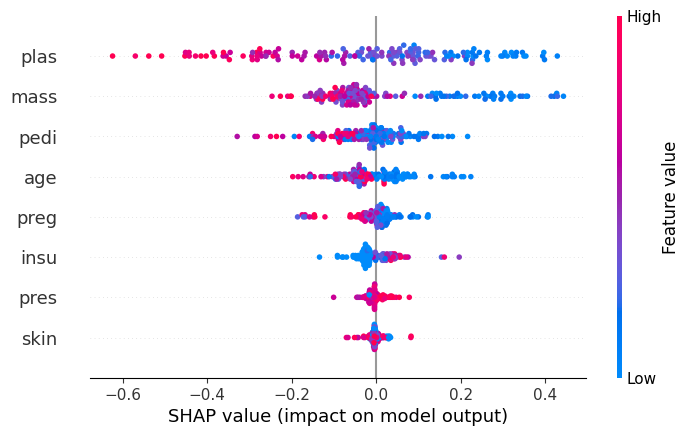

In [24]:
import shap
shap_values = rias.shap_explainer(X_test)
shap.plots.beeswarm(shap_values[:, :, 1])

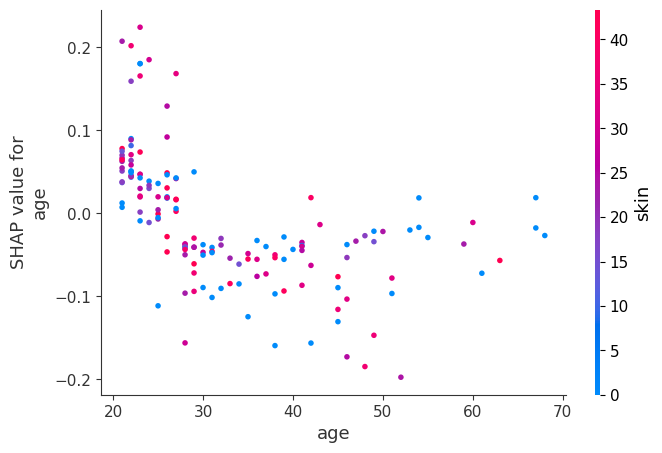

In [51]:
shap.dependence_plot("age", shap_values.values[:, :, 0], X_test, interaction_index=3)

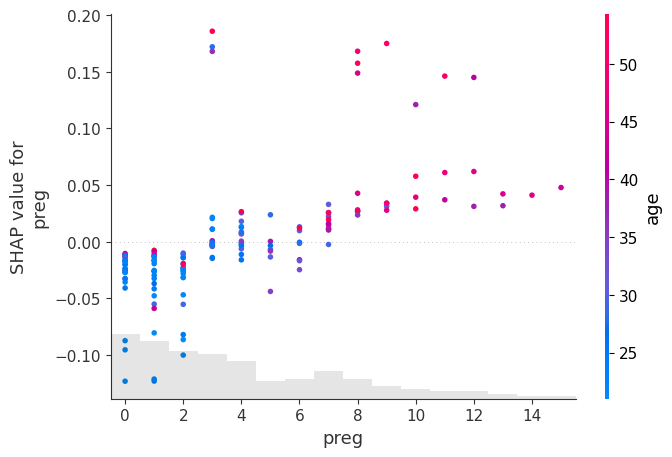

In [55]:
shap.plots.scatter(shap_values[:, "preg", 1], color=shap_values[:,:,1])